In [52]:
# imports

import math
import datetime
import time
import searchtweets
import pandas as pd

import string
import warnings
import datetime
warnings.filterwarnings('ignore')
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to /home/keras/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### getting the data

In [91]:
def get_tweet_object(search_term, start_date, end_date, num_of_tweets, include_retweets=True):
    
    '''
    takes:
    
    * date range
    * screen name
    * number of tweets to return (500 per page)
       
    input search term as a string
    
    input search range as datetime.datetime(20xx, 1, 20)
    
    include_retweets defaults is True. to exclude retweets set to False.
    
    returns: 
    
    * tweets object with replies to input screen name 
   
    '''
    
    
    search_args = searchtweets.load_credentials('twitter_keyz.yaml',
                                                yaml_key='search_tweets_api',
                                                env_overwrite=False)
    
    if include_retweets:
        
        search_term = search_term + ' lang:en'
    
    else:
        
        search_term = search_term + ' lang:en -is:retweet'
        
    
    
    rule = searchtweets.gen_rule_payload(search_term,
                                         results_per_call=500,
                                         from_date=start_date.strftime('%Y-%m-%d'),
                                         to_date=end_date.strftime('%Y-%m-%d'))     
        
    tweet_objects = []
    
    rs = searchtweets.ResultStream(rule_payload=rule,
                                   max_results=num_of_tweets,
                                   max_pages=math.ceil(num_of_tweets / 500.0),
                                   **search_args)
    
    start_time = time.time()
    
    # error handling & rate limiting for requests
    
    try:
        
        # generator 

        for i, tweet_object in enumerate(rs.stream(), start=1):
            
            # check every 500 requests, ie every page
        
            if i % 500 == 0:
            
                now = time.time()
                
                # four second delay
            
                if now < start_time + 4:
                
                    time.sleep(4 - (now - start_time))
                
                    start_time = time.time()
                
            tweet_objects.append(tweet_object)
    
    except Exception as e:
        
        print("Error from Twitter API: %s. Fetched %d tweet_objects" % (e, len(tweet_objects)))
    
    return tweet_objects

In [25]:
# test: see if we can get 100,000 tweets containing the 'r-dskins' slur/team name 

rdskins_tweet_objects = get_tweet_object('redskins', datetime.datetime(2007,1,24), datetime.datetime(2020,1,24), 100000, include_retweets=False)
    

Grabbing bearer token from OAUTH


In [26]:
rdskins_raw_df = tweet_obj_to_df(rdskins_tweet_objects)

In [27]:
print(len(rdskins_raw_df), '\n')

print(rdskins_raw_df.head(25))

100000 

                                                 text           author
0   @CandlestickWill @Redskins Thanks - have you s...    PaulNicholsDC
1   @Redskins @MDLottery @AP_Images @JoeGibbsRacin...      GaryBasnett
2   Redskins offensive lineman Brandon Scherff is ...     EmpireGotham
3   @swayrun21 And he’d be ANOTHER #Buckeye on the...       GuyBuckeye
4                 @UncleWellons @Redskins Can’t do it      _TommyMcCoy
5   'Redskins add two more to coaching staff in Br...       rmarine_75
6   'For the Redskins, the No. 2 pick is a win, ei...       rmarine_75
7   'Redskins should pay attention to pass catcher...       rmarine_75
8   @_rich_moore @JayKogen @AlJean @MikeReissWrite...    dailysimpsons
9   @BangRadioHour @Redskins True but not guarante...       wsk28rules
10  @Redskins @MDLottery @AP_Images @JoeGibbsRacin...  FredHarshberger
11  Throwing it back to the legendary Coach Joe Gi...         Redskins
12   @redskinsfyi @Trezaye @TreyyMB @Redskins They’re     bigbrussel

In [29]:
# save as csv

rdskins_raw_df.to_csv('rdskins_raw_df_Jan_24_2020.csv')

In [46]:
rdskin_tweet_objects = get_tweet_object('redskin', datetime.datetime(2007,1,24), datetime.datetime(2020,1,25), 100000, include_retweets=False)

Grabbing bearer token from OAUTH


In [47]:
# create raw df

rdskn_raw_df = tweet_obj_to_df(rdskin_tweet_objects)

In [48]:
print(len(rdskn_raw_df), '\n')

print(rdskn_raw_df.head())

100000 

                                                text           author
0  Taught some French for my Redskin Rumble activ...    mlwilliams614
1  @Inevitable_ET 49% SanFran cause I like Kyle (...       CRhinehold
2  @Arj_Romeo Tua, very unlikely that someone ahe...    JamesMurphy34
3  @Tiller56 In my experience you are the most le...  NorthernAZDevil
4  @bentleyhaskins I want to see him stay at this...    rant_redskins


In [49]:
rdskn_raw_df.to_csv('rdskin_raw_df_Jan_25_2020.csv')

## specific searches

I pulled a total 200,000 tweets containing the r-dskin slur; however this was just a drop in the bucket compared to the total number in existence. 

After checking to see whether certain terms appeared in the dataset, I decided to use the keyword search functionality in Twitter's API to look for specific words directly. 

My reasoning was that offensive words & phrases could be reasonably expected to appear with a racial slur; if the phrases appeared in the 'r-dskins' dataset, it would make sense to check them in others to compare how the words are used.

In [122]:
# ("Twitter" and "search")
# tweet_objects = get_tweet_object('redskin', datetime.datetime(2007,1,24), datetime.datetime(2020,1,25), 100000, include_retweets=False)

dr_tweet_objects = get_tweet_object('("redskins" and "dirty")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [123]:
# get df

dr_raw_df = tweet_obj_to_df(dr_tweet_objects)

print(len(dr_raw_df), '\n')

print(dr_raw_df.head())


2060 

                                                text          author
0  @ProFootballTalk @hwkbgr Philly fans complain ...      jyoaee2125
1  So over the last 72 hours:\n\n- the Birds get ...    Philly_Canes
2  @EvanMcMullin ✔    I'm a Redskins fan and born...  redskinsravens
3  Giants, Cowboys and Redskins fans when the res...   JimmyRandazzo
4  @ParkerHamlett @Redskins Saints and ravens her...       DougieD35


In [124]:
dr_raw_df.to_csv('dr_raw_df_Jan_25_2020.csv')

In [125]:
sr_tweet_objects = get_tweet_object('("redskins" and "stupid")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [126]:
# df: 'stupid' & 'r*dskin'

sr_raw_df = tweet_obj_to_df(sr_tweet_objects)

print(len(sr_raw_df), '\n')

print(sr_raw_df.head())

7782 

                                                text        author
0  @FedExField @Redskins @RSprachrohr Yall are so...  ForQuickNews
1  Only way I trade down if I’m the Redskins is i...   PeachOmania
2  @funnydanny Maryland is now Ravens country...c...       MiceM11
3  @RickMaese @ErinatThePost @OvettaWashPost Why ...      DeezNats
4  @Redskins @flightmarshalls We all should be a ...       jaydw83


In [127]:
sr_raw_df.to_csv('sr_raw_df_Jan_25_2020.csv')

In [128]:
ur_tweet_objects = get_tweet_object('("redskins" and "ugly")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [129]:
ur_raw_df = tweet_obj_to_df(ur_tweet_objects)

print(len(ur_raw_df), '\n')

print(ur_raw_df.head())

4011 

                                                text        author
0  The 2017 Vikings had a top ten offense with a ...  joe_thom1998
1  @davidgraeber not compete with sports teams fr...  PotemkinLion
2  @Jets_NEFL20 @Saints_NEFL20 @Redskins_NEFL20 Y...  Bears_NEFL20
3  @JPFinlayNBCS Twitter can be an ugly place. Lo...  John_Tyreman
4  @Jawn_BonJovi @Redskins Jawn, they are Racials...   MikeWiseguy


In [130]:
ur_raw_df.to_csv('ur_raw_df_Jan_25_2020.csv')

In [131]:
fr_tweet_objects = get_tweet_object('("redskins" and "filthy")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [132]:
# get dataframe

fr_raw_df = tweet_obj_to_df(fr_tweet_objects)

print(len(fr_raw_df), '\n')

print(fr_raw_df.head())

148 

                                                text          author
0  @ProFootballTalk Um my guess because of the ex...   HmichaelSmith
1  The sad part of this, @Giants only 1 in the la...       tomlapp66
2  @StoopKid1818 @OndreLeonard30 @Zirksee and the...    Nick48094751
3  @Bowblax He also said that the natives deserve...   Greg69Heffley
4  49’ers/Redskins is some nasty, filthy, throwba...  jamestingstrom


In [133]:
fr_raw_df.to_csv('fr_raw_df_Jan_25_2020.csv')

In [134]:
ri_tweet_objects = get_tweet_object('("redskins" and "indian")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [135]:
# get dataframe: r*dskins & Indian

ri_raw_df = tweet_obj_to_df(fr_tweet_objects)

print(len(ri_raw_df), '\n')

print(ri_raw_df.head())

148 

                                                text          author
0  @ProFootballTalk Um my guess because of the ex...   HmichaelSmith
1  The sad part of this, @Giants only 1 in the la...       tomlapp66
2  @StoopKid1818 @OndreLeonard30 @Zirksee and the...    Nick48094751
3  @Bowblax He also said that the natives deserve...   Greg69Heffley
4  49’ers/Redskins is some nasty, filthy, throwba...  jamestingstrom


In [136]:
ri_raw_df.to_csv('ri_raw_df_Jan_25_2020.csv')

In [139]:
rb_tweet_objects = get_tweet_object('("redskins" and "blood")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [140]:
rb_raw_df = tweet_obj_to_df(rb_tweet_objects)

print(len(rb_raw_df), '\n')

print(rb_raw_df.head())

1949 

                                                text        author
0  Law enforcement\nFrom a    Suitland and Redski...   JoeMcgill67
1  @DLoesch As someone with Cherokee blood! I am ...   gillburgkid
2  @BurgundyBlog Redskins need to get rid of all ...      cobane03
3  @Saints_NEFL20 @Jets_NEFL20 @Redskins_NEFL20 I...  Bears_NEFL20
4  A new season and a new look with some updated ...  DeuceDouglas


In [141]:
rb_raw_df.to_csv('rb_raw_df_Jan_25_2020.csv)')

In [143]:
rsc_tweet_objects = get_tweet_object('("redskins" and "scalp")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [144]:
rsc_raw_df = tweet_obj_to_df(rsc_tweet_objects)

print(len(rsc_raw_df), '\n')

print(rsc_raw_df.head())

370 

                                                text           author
0  @SNFonNBC @ProFootballTalk @CSimmsQB None of t...       RyanClear2
1  @Bobbin76818496 The last time a person used th...  FrancesMFDanger
2  @fuckcancer56 And why was he placed on injured...         bells110
3  REDSKINS NEED TO FIX THEIR ACT. Trent Williams...     keefer_aydon
4  @RMNarrative @EdgeofSports I don't think he'd ...    PettyWakandan


In [145]:
rsc_raw_df.to_csv('rsc_raw_df_Jan_25_2020.csv')

In [187]:
rsv_tweet_objects = get_tweet_object('("redskins" and "savage")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [188]:
rsv_raw_df = tweet_obj_to_df(rsv_tweet_objects)

print(len(rsv_raw_df), '\n')

print(rsv_raw_df.head())

539 

                                                text         author
0  Nick Bosa is the perfect example of why the Re...     HTTRChamps
1  If the Bengals shock and go Chase Young 1st ov...    HSprings719
2  @Savage_Package @94tilinfinite Are you a packe...     Rellihan51
3  @Savage_Torrey3 @ktewfikS @StephenChesser0 @Li...       Zachosh3
4  "Good job. You're kinda good at football."\n\n...  art_stapleton


In [189]:
rsv_raw_df.to_csv('rsv_raw_df_Jan_26_2020.csv')

In [150]:
rdd_tweet_objects = get_tweet_object('("redskins" and "dead")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [151]:
rdd_raw_df = tweet_obj_to_df(rdd_tweet_objects)

print(len(rdd_raw_df), '\n')

print(rdd_raw_df.head())

4171 

                                                text        author
0  @FedExField @Redskins @RSprachrohr Yall are so...  ForQuickNews
1  Redskins climbing this list once we cut some d...   stewiecoats
2  @Redskins @flightmarshalls We all should be a ...       jaydw83
3  Redskins player Montae Nicholson dropped an un...    TishaLewis
4  would love to have him opposite of mcclaurin. ...  bighomiehawk


In [152]:
rdd_raw_df.to_csv('rdd_raw_df_Jan_26_2020.csv')

In [153]:
rkl_tweet_objects = get_tweet_object('("redskins" and "killed")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [154]:
rkl_raw_df = tweet_obj_to_df(rkl_tweet_objects)

print(len(rkl_raw_df), '\n')

print(rkl_raw_df.head())

2870 

                                                text          author
0  @MattKHOU @Redskins @NFL This @NFL player viol...  SusanChanaLask
1  @JuiceCheck44 You’re a wizard kyle! Does that ...     RICKDOGG424
2  Do you actually think that the indigenous peop...        cultyooa
3  @CalsCruitin @VinceSchilling @49ers @Chiefs Ra...     Levi__Adams
4  @HStMovemberfest @TerrapinHoops @umterps It’s ...         shrshot


In [155]:
rkl_raw_df.to_csv('rkl_raw_df_Jan_26_2020.csv')

In [156]:
rsx_tweet_objects = get_tweet_object('("redskins" and "sexy")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [157]:
rsx_raw_df = tweet_obj_to_df(rsx_tweet_objects)

print(len(rsx_raw_df), '\n')

print(rsx_raw_df.head())

995 

                                                text           author
0  @BigManPauly @Redskins Expect the off season t...          sonnyg9
1  Russini: Ron Rivera hire smart but not sexy by...    RyboSkinsHTTR
2  @ANTallDay21 @JPFinlayNBCS chase young is the ...       fstaylor21
3  @diannaESPN as a Redskins fan im not sure what...  LafayetteAzvedo
4  Sexy hire? No. Smart? Infinitely. Columnist @J...       PostSports


In [158]:
rsx_raw_df.to_csv('rsx_raw_df_Jan_26_2020.csv')

In [159]:
rib_tweet_objects = get_tweet_object('("redskins" and "indian blood")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [160]:
rib_raw_df = tweet_obj_to_df(rib_tweet_objects)

print(len(rib_raw_df), '\n')

print(rib_raw_df.head())

20 

                                                text           author
0  And ... i have American Indian Blood and i Roo...       Naztitle01
1  @nictuttle @gsidebo @DavidAFrench I have more ...  quesogrande1970
2  AS AN ANDERSON ALUM AND SOMEONE THAT ACTUALLY ...       NahBabyNah
3  @Andrew_B_Bader @hankschulman Why? I have have...          3426674
4  REDSKINS IS NOT RACIST NAME FUCKING A MAN HOLY...   _____Squidward


In [161]:
rib_raw_df.to_csv('rib_raw_df_Jan_26_2020.csv')

In [162]:
rrsv_tweet_objects = get_tweet_object('("redskins" and "reservation")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [163]:
rrsv_raw_df = tweet_obj_to_df(rrsv_tweet_objects)

print(len(rrsv_raw_df), '\n')

print(rrsv_raw_df.head())

458 

                                                text          author
0  Apartheid at Pechanga Reservation. Yes, Segreg...       opechanga
1  @VinceSchilling @49ers @Chiefs @NFL @Redskins ...  RealbrianBlade
2  @VinceSchilling @49ers @Chiefs @VinceSchilling...       KaraJenne
3  @VinceSchilling @49ers @Chiefs @NFL You know a...        bigs1226
4  @DesertHawk99 @bmcsusn1963 @VinceSchilling @49...         jam4821


In [164]:
rrsv_raw_df.to_csv('rrsv_raw_df_Jan_26_2020.csv')

In [165]:
rsmp_tweet_objects = get_tweet_object('("redskins" and "smallpox")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [166]:
rsmp_raw_df = tweet_obj_to_df(rsmp_tweet_objects)

print(len(rsmp_raw_df), '\n')

print(rsmp_raw_df.head())

138 

                                                text      author
0  Whether it's the first to be the Patriots givi...  testing_a1
1  Karma would mean the Aboriginal Ppl would own ...       DrN0_
2  redskins will make baby yoda beaded jewelry an...  buffpharah
3  #Blakes7 Season 2, Episode 07 - Killer\nBLAKE:...  blakes7bot
4  Season 2, Episode 07 - Killer\nBLAKE:  Mm, pre...  blakes7bot


In [167]:
rsmp_raw_df.to_csv('rsmp_raw_df_Jan_26_2020.csv')

In [170]:
rdrk_tweet_objects = get_tweet_object('("redskins" and "drunk")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [171]:
rdrk_raw_df = tweet_obj_to_df(rdrk_tweet_objects)

print(len(rdrk_raw_df), '\n')

print(rdrk_raw_df.head())

1797 

                                                text           author
0  @VinceSchilling @49ers @Chiefs What does Vince...  JaneJon54227850
1  Very much worth reading.\n\nI got into a drunk...      irritated_1
2  @WojoYah00NBA @TylerIAm The cardinals gm got a...        charkmeal
3  @stephenasmith @Browns @dallascowboys @Giants ...          jcraw40
4  @czabe I once wore a Randy Moss jersey to a Re...    JockSupporter


In [172]:
rdrk_raw_df.to_csv('rdrk_raw_df_Jan_26_2020.csv')

In [173]:
rinj_tweet_objects = get_tweet_object('("redskins" and "injun")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [174]:
rinj_raw_df = tweet_obj_to_df(rinj_tweet_objects)

print(len(rinj_raw_df), '\n')

print(rinj_raw_df.head())

54 

                                                text           author
0  Generations later, my relatives are far more e...           AudryT
1  Elizabeth Warren a Direct Descendant of Militi...  FormerRepublic9
2  we redskins aren’t going to march into korea p...          Iucasmr
3  @BreitbartNews And as an injun she should know...       kdodson106
4  Goddammit, two of the top songs I want to do a...       NekoMcEvil


In [175]:
rinj_raw_df.to_csv('rinj_raw_df_Jan_26_2020.csv')

In [176]:
rextr_tweet_objects = get_tweet_object('("redskins" and "exterminate")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [177]:
rextr_raw_df = tweet_obj_to_df(rextr_tweet_objects)

print(len(rextr_raw_df), '\n')

print(rextr_raw_df.head())

8 

                                                text           author
0  @thehill Hitler's plan was to create extra liv...            adze4
1  @MattWalshBlog Let's not forget he also normal...        scsimodem
2  @WASBAPPIN @AllCopsAreIncel @puristwhiner @chi...  thegrahamcanyon
3  @clugstack @dearnonnatives @_nicholus3 @lilnat...        AliNahdee
4  @ACLU @ACLUVA @RVAwonk @Redskins WHEN YOU HAVE...         blogdiva


In [178]:
rextr_raw_df.to_csv('rextr_raw_df_Jan_26_2020.csv')

In [179]:
rext_tweet_objects = get_tweet_object('("redskins" and "extinct")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [180]:
rext_raw_df = tweet_obj_to_df(rext_tweet_objects)

print(len(rext_raw_df), '\n')

print(rext_raw_df.head())

28 

                                                text          author
0  This is in response to a local school district...  gretelkauffman
1  @LakeRaMan Didn’t miss a single LA Rams game f...       JBroFronk
2  @franchescag97 Basically. The native American ...  MakeupWhoreder
3  @nfl this league gets worse and worse every ye...     kidkapper10
4  They were murdered, raped, forced from their h...         EsAy313


In [181]:
rext_raw_df.to_csv('rext_raw_df_Jan_26_2020.csv')

In [182]:
rfw_tweet_objects = get_tweet_object('("redskins" and "firewater")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [183]:
rfw_raw_df = tweet_obj_to_df(rfw_tweet_objects)

print(len(rfw_raw_df), '\n')

print(rfw_raw_df.head())

25 

                                                text           author
0  @ewarren Oh Lizzy..This is the GREATEST News E...    rebelfrom1944
1  Man, if we Redskins only had those instead of ...  William42870346
2  Strange smoke signals and scary loud music in ...      WWPFInsider
3  @JoyAnnReid Just like the redskins and that fi...  patrickfcox_cox
4  Third, #SonicDriveIn most disturbing 2 scalpin...  EmmyNawjoopinga


In [184]:
rfw_raw_df.to_csv('rfw_raw_df_Jan_26_2020.csv')

In [190]:
rig_tweet_objects = get_tweet_object('("redskins" and "ignorant")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [191]:
rig_raw_df = tweet_obj_to_df(rig_tweet_objects)

print(len(rig_raw_df), '\n')

print(rig_raw_df.head())

967 

                                                text           author
0  @ztipton85 @espn @Chiefs @Redskins As a woman ...  AriannaChavarr1
1  @Redsunhero @bmcsusn1963 And I am 50. I rememb...       RJ_Number8
2  @rant_redskins @powhatannative @don1964a @Skru...     NudaleKawonu
3  @Skrub_3 @PrincessKnightD @BradGGallant @Burgu...   TheBandGreport
4  @CrunkATL @Redskins As ignorant as they are, t...           FTCUTD


In [192]:
rig_raw_df.to_csv('rig_raw_df_Jan_26_2020.csv')

In [193]:
rlz_tweet_objects = get_tweet_object('("redskins" and "lazy")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [194]:
rlz_raw_df = tweet_obj_to_df(rlz_tweet_objects)

print(len(rlz_raw_df), '\n')

print(rlz_raw_df.head())

715 

                                                text         author
0  @Kareem_captain1 @Habib1852 I can't. I'm not i...      john_keim
1  @Bwats21 @bentleyhaskins Exactly.  People like...    BrandonW573
2  @Bungie Bungie needs to get off there a**es an...  stephenshook1
3  @SBNation .... Redskins beat the Panthers on t...    EmbersToAsh
4  @pantherpundit @officialsdrd @Redskins Stop it...       N_Z_A_15


In [196]:
rlz_raw_df.to_csv('rlz_raw_df_Jan_26_2020.csv')

In [4]:
rsa_tweet_objects = get_tweet_object('("redskins" and "raped")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [5]:
rsa_raw_df = tweet_obj_to_df(rsa_tweet_objects)

print(len(rsa_raw_df), '\n')

print(rsa_raw_df.head())

363 

                                                text        author
0  @HeatleyJared Yea I get that, for me, my entir...  RedskinsRant
1  @KevinWhoItBe And I hope the redskins get rape...     nail_sahn
2  @Liz_Cheney Why do #NativeAmericans have to to...    kaimatters
3  I can’t wait to watch the Eagles get ass raped...      DanoSoko
4  @aprildeming With respect, I think this is a S...      Omcgill1


In [6]:
rsa_raw_df.to_csv('rsa_raw_df_Jan27_2020.csv')

In [7]:
rdb_tweet_objects = get_tweet_object('("redskins" and "dumb")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [8]:
rdb_raw_df = tweet_obj_to_df(rdb_tweet_objects)

print(len(rdb_raw_df), '\n')

print(rdb_raw_df.head())

5718 

                                                text          author
0  @TheDMVDailyy @Redskins This dumb as hell. Y’a...  DaBeardologist
1  @JackMBDTF @DakZekeCooper @BleacherReport @brg...   slevin_heaven
2  @MattFontana83 No and I wish the organization ...     jkingery727
3  What I don't understand is that there is a but...  kevinsheehanjc
4  @Nate_Neal27 @TarantinoMike94 @GoPack1233 @Kee...   DillyDillyy87


In [9]:
rdb_raw_df.to_csv('rdb_raw_df_Jan_27_2020.csv')

In [10]:
rbw_tweet_objects = get_tweet_object('("redskins" and "backwards")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [11]:
rbw_raw_df = tweet_obj_to_df(rbw_tweet_objects)

print(len(rbw_raw_df), '\n')

print(rbw_raw_df.head())

674 

                                                text         author
0  @BarstoolReags Redskins +4.5 vs Eagles this ye...      GTRandy27
1  Why does anyone want to see Amari Cooper in a ...         ke0477
2  @stephenasmith @Browns @dallascowboys @Giants ...         xROC7x
3  @stephenasmith @Browns @dallascowboys @Giants ...  FrankRomeo213
4  @stephenasmith @Browns @dallascowboys @Giants ...        dupri28


In [12]:
rbw_raw_df.to_csv('rbw_raw_df_Jan_27_2020')

In [13]:
rnbr_tweet_objects = get_tweet_object('("redskins" and "inbred")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [14]:
rnbr_raw_df = tweet_obj_to_df(rnbr_tweet_objects)

print(len(rnbr_raw_df), '\n')

print(rnbr_raw_df.head())

16 

                                                text           author
0  @skinz25 @bpman11 @CelticsIn2 @Eagles Based on...  JerryJonesGhost
1  I’m pretty sure we are all dead, and being a #...  RedskinsAddicts
2  @ChipReiderson Apparently one of these inbred ...     DaveHarris73
3  Name Change "Washington RedSKINS? How about a ...  JamesMichaelCr6
4  @espn980 @Redskins @thecooleyzone @kevins980 A...        Zaktronic


In [15]:
rnbr_raw_df.to_csv('rnbr_raw_df_Jan_27_2020.csv')

In [16]:
rd_tweet_objects = get_tweet_object('("redskins" and "died")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [20]:
rd_raw_df = tweet_obj_to_df(rd_tweet_objects)

print(len(rd_raw_df), '\n')

print(rd_raw_df.head(20))

1167 

                                                 text           author
0   Woman, 21, dropped off at ER by Redskins playe...    Man76Infantry
1   Woman, 21, dropped off at ER by Redskins playe...          Jaize18
2   Woman, 21, dropped off at ER by Redskins playe...      RitchieJodi
3   Woman, 21, dropped off at ER by Redskins playe...    T_dot_Lee_PhD
4   Woman, 21, dropped off at ER by Redskins playe...      shiawase428
5   Woman, 21, dropped off at ER by Redskins playe...         GaBrat66
6   Woman, 21, dropped off at ER by #Redskins play...     GlobalNewsTH
7   Autopsy result reveals Julia Crabbe died from ...    KolbieReports
8   This is terrible and sad. Why are such accompl...       Autopsy_MD
9   The 21-year-old woman who was brought unconsci...     nexxlvlconvo
10  Julia Crabbe, 21 yr. old friend of Montae Nich...     mikejbabcock
11  No sense in debating this any more. The issue ...   RedskinsReview
12  @WRC_Candess @1stLadiesOfFB @KissProducts @Red...     andythebutts

In [27]:
rd_raw_df.to_csv('rd_raw_df_Jan_27_2020.csv')

In [19]:
rde_tweet_objects = get_tweet_object('("redskins" and "die")', datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 25000, include_retweets=False)

Grabbing bearer token from OAUTH


In [28]:
rde_raw_df = tweet_obj_to_df(rde_tweet_objects)

print(len(rde_raw_df), '\n')

print(rde_raw_df.head(20))

5699 

                                                 text           author
0   As a die hard @Redskins fan I hated playing ag...    Someoneplace8
1   Wishing the happiest of birthdays to my favori...      hammNchees3
2   @steelercam I have a friend who’s a 💯% Redskin...       mztweeylu2
3   Kyle Shanahan is now headed to his 2nd Super B...      RawlingsA82
4   Growing up in Va Beach, I was a diehard Chiefs...        crazypnut
5   @gold_jag5 @TonyKhan @YannickNgakoue You’re a ...    WhyAmIhere_27
6   @jenniferpierson I'd die before I ever rooted ...         Skykam1_
7   I'm a Ride or Die Redskins Fan sir but I give ...       Blondheim3
8   This is the only pic I have of him. He was a d...       JLBfromDVM
9   A Racist problem. Unfortunately Almost all of ...        LarTheTar
10  Hey @cowboys fans imma die hard @Redskins fan,...       bisonskins
11  I am die hard redskins fan but damnn I know my...  Santana_Diabloo
12  I will die on this hill - but @RiverboatRonHC ...   travis_holland

In [29]:
rde_raw_df.to_csv('rde_raw_df_Jan_27_2020.csv')

In [209]:
# combine all queries to create master dataframe

DFs = [dr_raw_df, sr_raw_df, ur_raw_df,
       fr_raw_df, ri_raw_df, rb_raw_df,
       rsc_raw_df, rsv_raw_df, rdd_raw_df,
       rkl_raw_df, rsx_raw_df, rib_raw_df,
       rrsv_raw_df, rsmp_raw_df, rdrk_raw_df,
       rinj_raw_df, rextr_raw_df, rext_raw_df,
       rfw_raw_df, rig_raw_df, rlz_raw_df
      ]

rs_queries_master_df = pd.DataFrame()

for df in DFs:
    
    rs_queries_master_df = rs_queries_master_df.append(df, ignore_index=True)
    

In [210]:
print(len(rs_queries_master_df), '\n')

print(rs_queries_master_df.head(25))

29253 

                                                 text          author
0   @ProFootballTalk @hwkbgr Philly fans complain ...      jyoaee2125
1   So over the last 72 hours:\n\n- the Birds get ...    Philly_Canes
2   @EvanMcMullin ✔    I'm a Redskins fan and born...  redskinsravens
3   Giants, Cowboys and Redskins fans when the res...   JimmyRandazzo
4   @ParkerHamlett @Redskins Saints and ravens her...       DougieD35
5   @Urunderarrest I wore a Bears jersey ONCE for ...   Da_Blues_6564
6   "An inveterate tomboy from the start, I spent ...  justquisquilia
7   During Allen’s tenure, did you notice,anyone w...     karl_diesel
8   Looks like the Redskins finally have a legit h...     curtisd0101
9   Ight @Lakers my @Redskins did me dirty this ye...        EazyE302
10  I think it’s fair to say that @JJWatt ruined t...         Caps239
11  @granthpaulsen The @Redskins can’t even fire a...   Marylandmike4
12  If the #redskins tied Dallas and the Eagles wo...    DArkMEATHOOK
13  @roshonp

In [205]:
# save to csv

rs_queries_master_df.to_csv('rs_queries_master_df_Jan_26_2020.csv')

In [63]:
rs_working_df = pd.read_csv('rs_queries_master_df_Jan_26_2020.csv')

print(len(rs_working_df))

rs_working_df.head()

29255


,Unnamed: 0,text,author
0,0,@ProFootballTalk @hwkbgr Philly fans complain ...,jyoaee2125
1,1,So over the last 72 hours:\n\n- the Birds get ...,Philly_Canes
2,2,@EvanMcMullin ✔ I'm a Redskins fan and born...,redskinsravens
3,3,"Giants, Cowboys and Redskins fans when the res...",JimmyRandazzo
4,4,@ParkerHamlett @Redskins Saints and ravens her...,DougieD35


In [64]:
# add later terms tested
# rs_working_df is reloaded rs_df

DFs = [rsa_raw_df, rdb_raw_df, rbw_raw_df,
       rnbr_raw_df, rd_raw_df, rde_raw_df]

for df in DFs:
    
    rs_working_df = rs_working_df.append(df, ignore_index=True)

In [65]:
print(len(rs_working_df))

42892


In [66]:
rs_working_df.to_csv('rs_queries_master_df_Jan_26_2020.csv')

### testing other teams

Once I had gathered a list of terms that appear with the team name "Redskins", I could check other teams against the same list for comparison.

In [70]:
def try_terms(team_name):
    
    '''
    takes:
    
    * team name as a string
    
    returns:
    
    * dataframe with all tweets containing the team name & search terms
    * up to 10k results (tweets) per term
    
    '''
    
    term_list = ['dirty','filthy','stupid','ugly','indian',
             'blood','scalp','savage','dead','killed',
             'sexy','indian blood','drunk','injun',
             'exterminate','extinct','firewater',
             'reservation','smallpox','ignorant',
             'raped','die','dumb','backwards',
             'inbred','died']
    
    raw_df = pd.DataFrame()
    
    for term in term_list:
        
            # create search string
        
            search_term = '("' + team_name + '" and "' + term + '")'
            
            tweet_objects = get_tweet_object(search_term, datetime.datetime(2007,1,1), datetime.datetime(2020,1,25), 10000, include_retweets=False)
            
            tweet_obj_df = tweet_obj_to_df(tweet_objects)

            raw_df = raw_df.append(tweet_obj_df)

            print(len(raw_df), '\n')

            print(raw_df.head(20))
            
    return raw_df
           

In [71]:
chiefs_queries_master_df = try_terms('chiefs')

Grabbing bearer token from OAUTH


3037 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez45

Grabbing bearer token from OAUTH


3312 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez45

Grabbing bearer token from OAUTH


13312 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez4

Grabbing bearer token from OAUTH


18415 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez4

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


27743 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez4

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


32214 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez4

Grabbing bearer token from OAUTH


32979 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez4

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


50612 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez4

Grabbing bearer token from OAUTH


51385 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez4

Grabbing bearer token from OAUTH


51396 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez4

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


54493 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez4

Grabbing bearer token from OAUTH


54508 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez4

Grabbing bearer token from OAUTH


54557 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez4

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


55031 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez4

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


56766 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez4

Grabbing bearer token from OAUTH


57271 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez4

Grabbing bearer token from OAUTH


65223 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez4

Grabbing bearer token from OAUTH


72720 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez4

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


72800 

                                                 text           author
0   @BigDrewandJim Stafford could absolutely pull ...         skearn41
1   Kaizer Chiefs blacklisted Mandla Masango and T...  LUCKY_MTHOMBENI
2   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
3   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
4   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
5   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
6   @martyclevenger @ProFootballTalk Florio has a ...      brettoncole
7   @ProFootballTalk @MikeFlorioPFT this is ridicu...       mellanclos
8   @ProFootballTalk The fuck you talkin bout smfh...      SAWAIIAN650
9   @ProFootballTalk How do the Chiefs stop that r...      book_nelson
10  Why are we even having an election against law...      redalertnow
11  @zach_seibel21 @NBCSports @ProFootballTalk We ...         hotchman
12  @ProFootballTalk It's not just Chiefs fans whi...     auntiesuez4

In [72]:
print(len(chiefs_queries_master_df))

75513


In [100]:
chiefs_queries_master_df.to_csv('chiefs_queries_master_df_Jan_28_2020.csv')

In [85]:
# test

c_test_df1 = chiefs_queries_master_df[chiefs_queries_master_df['text'].str.contains('dead')]

c_test_df2 = chiefs_queries_master_df[chiefs_queries_master_df['text'].str.contains('Dead')]

print(len(c_test_df1), '\n')

print(len(c_test_df2), '\n')

print(len(c_test_df1) + len(c_test_df2))

6539 

1014 

7553


In [79]:
sf_49ers_queries_master_df = try_terms('49ers')

Grabbing bearer token from OAUTH


2193 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49er

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


2384 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49er

Grabbing bearer token from OAUTH


13963 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


14139 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


15895 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH


16798 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH


20823 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH


24778 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH


25762 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH


25764 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH


27651 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH


27654 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH


27659 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH


27689 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


27843 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH


27846 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH


28346 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH


34258 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH


39212 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH


39733 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH


39749 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

Grabbing bearer token from OAUTH


41098 

                                                 text           author
0   @Triplebake88 @DanSileoShow @ProFootballTalk @...       Thomason03
1   @Phillies_49ers @codymurray1 @JeffAllen71 100%...         ZhombieV
2   So Florio's way out of the mess he's gotten hi...   Aksala07273193
3   @5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...        9nerGang5
4   @AB_3127 @ProFootballTalk 100% of 49ers fans H...       MyleStates
5   @Ragnod49 @ArrowheadAddict Much respect!! \n\n...     ArrighiOrosz
6   @davidmakepeace @ArrowheadAddict Chiefs fan he...     ArrighiOrosz
7   @ProFootballTalk You also said Jimmy was gonna...          Turo420
8   I think I'm rooting for Mahomes and the Chiefs...      skepticgoat
9   @JeffAllen71 @ProFootballTalk The 49ers don't ...    DaRealLopeezi
10  I was an Infantryman. I believe in the trenche...    InspireMe2287
11  @pattyWarren13 @ProFootballTalk Niners fans sh...     ArrighiOrosz
12  @emmerz08 @YourBoyRocha So basically no one sa...  H0neybadger49e

In [80]:
sf_49ers_queries_master_df.to_csv('sf_49ers_queries_master_df_Jan_28_2020.csv')

In [84]:
sf_test_df1 = sf_49ers_queries_master_df[sf_49ers_queries_master_df['text'].str.contains('dead')]

sf_test_df2 = sf_49ers_queries_master_df[sf_49ers_queries_master_df['text'].str.contains('Dead')]

print(len(sf_test_df1), '\n')

print(len(sf_test_df2), '\n')

print(len(sf_test_df1) + len(sf_test_df2))

3295 

690 

3985


In [93]:
def create_term_df(df, term):
    
    '''
    takes input dataframe & string search term
    
    finds all rows containing search term
    
    returns dataframe with rows & 'term' column
    
    '''
    
    term_df = df[df['text'].str.contains(term, case=False)]
    
    term_df['term'] = term
    
    return term_df


In [95]:
def get_full_terms_df(raw_df, terms_list):
    
    '''
    takes input raw dataframe
    
    gets all rows containing each term
    
    returns dataframe with all terms rows & "terms" column
    
    '''
    
    full_terms_df = pd.DataFrame()
    
    for term in terms_list:
    
        term_df = create_term_df(raw_df, term)
        
        full_terms_df = full_terms_df.append(term_df)
        
    return full_terms_df
    

In [96]:
term_list = ['dirty','filthy','stupid','ugly','indian',
             'blood','scalp','savage','dead','killed',
             'sexy','indian blood','drunk','injun',
             'exterminate','extinct','firewater',
             'reservation','smallpox','ignorant',
             'raped','die','dumb','backwards',
             'inbred','died']

### building dataframes

now i can go through each row & check to see whether my search terms exist in any case (upper, lower, etc) then add a label column containing the particular term, and finally create a new dataframe for each team with all rows clearly labeled for the term they contain.

#### San Francisco 49ers Dataframe

In [97]:
# get rows containing terms from the original raw df
# add a label column

sf_49ers_terms_full_df = get_full_terms_df(sf_49ers_queries_master_df, term_list)

In [98]:
print(len(sf_49ers_terms_full_df))

sf_49ers_terms_full_df.head(50)

44504


,text,author,term
0,@Triplebake88 @DanSileoShow @ProFootballTalk @...,Thomason03,dirty
1,@Phillies_49ers @codymurray1 @JeffAllen71 100%...,ZhombieV,dirty
2,So Florio's way out of the mess he's gotten hi...,Aksala07273193,dirty
3,@5ivves @m_vogan @pebdog5 @AB_3127 @ProFootbal...,9nerGang5,dirty
4,@AB_3127 @ProFootballTalk 100% of 49ers fans H...,MyleStates,dirty
5,@Ragnod49 @ArrowheadAddict Much respect!! \n\n...,ArrighiOrosz,dirty
6,@davidmakepeace @ArrowheadAddict Chiefs fan he...,ArrighiOrosz,dirty
7,@ProFootballTalk You also said Jimmy was gonna...,Turo420,dirty
8,I think I'm rooting for Mahomes and the Chiefs...,skepticgoat,dirty
9,@JeffAllen71 @ProFootballTalk The 49ers don't ...,DaRealLopeezi,dirty


In [101]:
# save to csv 

sf_49ers_terms_full_df.to_csv('sf_49ers_terms_full_df.csv')

#### Kansas City Chiefs Dataframe

In [103]:
# get dataframe

kc_chiefs_terms_full_df = get_full_terms_df(chiefs_queries_master_df, term_list)

In [104]:
print(len(kc_chiefs_terms_full_df))

kc_chiefs_terms_full_df.head(25)

82386


,text,author,term
0,@BigDrewandJim Stafford could absolutely pull ...,skearn41,dirty
1,Kaizer Chiefs blacklisted Mandla Masango and T...,LUCKY_MTHOMBENI,dirty
2,@Ragnod49 @ArrowheadAddict Much respect!! \n\n...,ArrighiOrosz,dirty
3,@davidmakepeace @ArrowheadAddict Chiefs fan he...,ArrighiOrosz,dirty
4,I think I'm rooting for Mahomes and the Chiefs...,skepticgoat,dirty
5,@JeffAllen71 @ProFootballTalk The 49ers don't ...,DaRealLopeezi,dirty
6,@martyclevenger @ProFootballTalk Florio has a ...,brettoncole,dirty
7,@ProFootballTalk @MikeFlorioPFT this is ridicu...,mellanclos,dirty
8,@ProFootballTalk The fuck you talkin bout smfh...,SAWAIIAN650,dirty
9,@ProFootballTalk How do the Chiefs stop that r...,book_nelson,dirty


In [106]:
# save to csv

kc_chiefs_terms_full_df.to_csv('kc_chiefs_terms_full_df.csv')

#### Washington R-dskins Dataframe

In [107]:
# get dataframe

wa_rs_terms_full_df = get_full_terms_df(rs_working_df, term_list)

In [108]:
print(len(wa_rs_terms_full_df))

wa_rs_terms_full_df.head(25)

45878


,Unnamed: 0,author,text,term
0,0,jyoaee2125,@ProFootballTalk @hwkbgr Philly fans complain ...,dirty
1,1,Philly_Canes,So over the last 72 hours:\n\n- the Birds get ...,dirty
2,2,redskinsravens,@EvanMcMullin ✔ I'm a Redskins fan and born...,dirty
3,3,JimmyRandazzo,"Giants, Cowboys and Redskins fans when the res...",dirty
4,4,DougieD35,@ParkerHamlett @Redskins Saints and ravens her...,dirty
5,5,Da_Blues_6564,@Urunderarrest I wore a Bears jersey ONCE for ...,dirty
6,6,justquisquilia,"""An inveterate tomboy from the start, I spent ...",dirty
7,7,karl_diesel,"During Allen’s tenure, did you notice,anyone w...",dirty
8,8,curtisd0101,Looks like the Redskins finally have a legit h...,dirty
9,9,EazyE302,Ight @Lakers my @Redskins did me dirty this ye...,dirty


In [109]:
# save to csv

wa_rs_terms_full_df.to_csv('wa_rs_terms_full_df.csv')

### how many offensive terms exist in each team's data set?

we can check to see how many of the 27 offensive terms appear in conjunction with each team's name:

In [114]:
terms_in_49ers = len(sf_49ers_terms_full_df)

terms_in_rs = len(wa_rs_terms_full_df)

terms_in_chiefs = len(kc_chiefs_terms_full_df)

total_offensive_terms = terms_in_49ers + terms_in_rs + terms_in_chiefs

print('offensive terms/phrases mentioned with the San Francisco 49ers: ', terms_in_49ers)

print('offensive terms/phrases mentioned with the Washington R*dskins: ', terms_in_rs)

print('offensive terms/phrases mentioned with the Kansas City Chiefs: ', terms_in_chiefs)

print('total offensive terms/phrases in 49ers, R*dskins, & Chiefs tweets: ', total_offensive_terms)

offensive terms/phrases mentioned with the San Francisco 49ers:  44504
offensive terms/phrases mentioned with the Washington R*dskins:  45878
offensive terms/phrases mentioned with the Kansas City Chiefs:  82386
total offensive terms/phrases in 49ers, R*dskins, & Chiefs tweets:  172768


### the verdict: over 170,000 offensive words & phrases

I was able to find a total of 172,768 offensive terms & phrases used in conjunction with racist team names like the R-dskins & the the Chiefs.

The NFL, team owners, & fans claiming that Washington's use of a slur as its team name is not offensive will need to explain away over 45,000 tweets containing violent and/or offensive imagery. This dataset is a resounding counter to the claim that the slur "r-dskins" is no longer used offensively. 

The two teams in the 2020 Super Bowl provide the most telling comparison, since these teams could be expected to share a relatively similar amount of "trash talk" in the days leading up to the game. 

However that is not what the data show, and the difference could not be more stark: while the San Francisco 49ers team name is itself problematic with deep anti-Indigenous connotations, as demonstrated by over 44,000 rows of tweets containing offensive words & imagery, **the Kansas City Chiefs dataset is nearly twice as long, at *82,386* tweets.**

## visualizing anti-Indigenous speech around Native mascots

With the data gathered, it's possible to visualize just how closely teams with Native-themed names are linked to racist speech.

#### Combining Dataframes

In [132]:
# term dataframes: 
# wa_rs_terms_full_df, kc_chiefs_terms_full_df, sf_49ers_terms_full_df

Not_Your_Mascot_full_df = pd.DataFrame()

Not_Your_Mascot_full_df = Not_Your_Mascot_full_df.append(wa_rs_terms_full_df, ignore_index=True)

Not_Your_Mascot_full_df = Not_Your_Mascot_full_df.append(kc_chiefs_terms_full_df, ignore_index=True)

Not_Your_Mascot_full_df = Not_Your_Mascot_full_df.append(sf_49ers_terms_full_df, ignore_index=True)

Not_Your_Mascot_full_df = Not_Your_Mascot_full_df.loc[:, ~Not_Your_Mascot_full_df.columns.str.contains('^Unnamed')]



In [133]:
print(len(Not_Your_Mascot_full_df))

print(Not_Your_Mascot_full_df.head())

172768
           author   term                                               text
0      jyoaee2125  dirty  @ProFootballTalk @hwkbgr Philly fans complain ...
1    Philly_Canes  dirty  So over the last 72 hours:\n\n- the Birds get ...
2  redskinsravens  dirty  @EvanMcMullin ✔    I'm a Redskins fan and born...
3   JimmyRandazzo  dirty  Giants, Cowboys and Redskins fans when the res...
4       DougieD35  dirty  @ParkerHamlett @Redskins Saints and ravens her...


In [134]:
# save to csv

Not_Your_Mascot_full_df.to_csv('Not_Your_Mascot_full_df.csv')

#### Visualizing the Data: General Distributions & Trends for All Three Teams

The bar chart below shows frequencies for each term, drawn from the entire dataset. Even with the inclusion of the ostensibly racially-neutral 49ers, it's easy to see racially-linked speech heavily represented in the corpus.

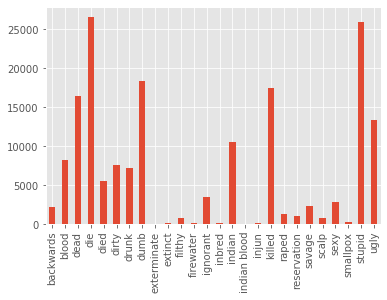

In [136]:
# bar chart for full dataset
# frequencies per term for all teams

Not_Your_Mascot_full_df['term'].value_counts().sort_index().plot.bar()